In [1]:
import PLred.mapmodel as mm
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import minimize
from scipy.ndimage import center_of_mass
import emcee
import PLred.fit as fit


In [2]:
# couplingmap_file = '/Users/yjkim/Documents/PLexperiments/data/visPL/2024-09-17/betcmi/empirical_couplingmap_w3n15_var.fits'
# data_spec = np.nansum(fits.open(couplingmap_file)[0].data[7,7], axis=0)
# model_file = '/Users/yjkim/Documents/PLred/PLred/examples/example_model_couplingmap/betcmi_20240917_polymodel_14:55:00_15:10:00.fits'
# m = mm.CouplingMapModel(model = model_file)

# image_ngrid = 33
# image_fov = 20
# n_trim = 1
# specind = 108
# fiber_inds = np.arange(38)

# fitter = fit.PLMapFit(model_file = model_file, image_ngrid = image_ngrid, 
#                       image_fov = image_fov, n_trim = n_trim)
# fitter.make_matrix(specind, fiber_inds)

In [3]:
specind = 107 #109
timeind = 3

fitter2 = fit.PLMapFit(matrix_file = '/Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind%d_ngrid33_t%d.fits' % (specind, timeind))

# fitter2 = fit.PLMapFit(matrix_file = '../example_image_reconstruction/matrix_specind%d.fits' % specind)

loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind107_ngrid33_t3.fits specind 107


In [4]:
fiber_inds = np.arange(38)

fitter2.prepare_data(fiber_inds)


preparing data for specind 107


In [5]:
np.shape(fitter2.mat)

(1089, 6422)

In [6]:
rc0 = fitter2.run_mcmc_pointsource(1, np.array([16,16]))
x0 = np.average(rc0.sampler.get_chain(discard=100, flat=True)[:,1])
y0 = np.average(rc0.sampler.get_chain(discard=100, flat=True)[:,0])

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:01<00:00, 991.28it/s]


In [7]:
rc = fitter2.run_mcmc_gaussian(np.array([x0,y0,1.5,2.5,0]), ini_ball_size=0.05, niter = 1000)
# rc = fitter2.run_mcmc_pointsource(2, np.array([16,16, 0.5, 17, 14]))

100%|██████████| 1000/1000 [01:26<00:00, 11.52it/s]


In [8]:
chain = rc.sampler.get_chain(flat=True)


In [9]:
np.shape(chain)

(10000, 5)

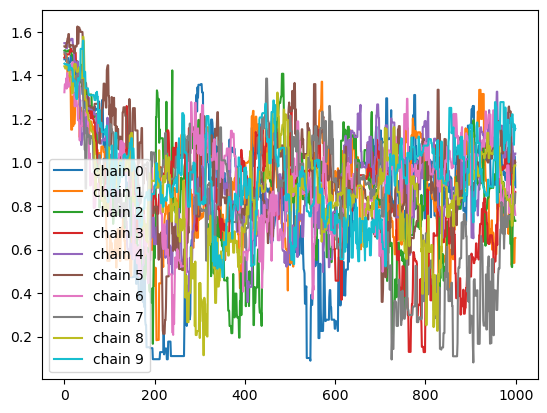

In [10]:
for i in range(10):
    plt.plot(rc.sampler.get_chain()[:,i,2], label='chain %d' % i)

plt.legend()

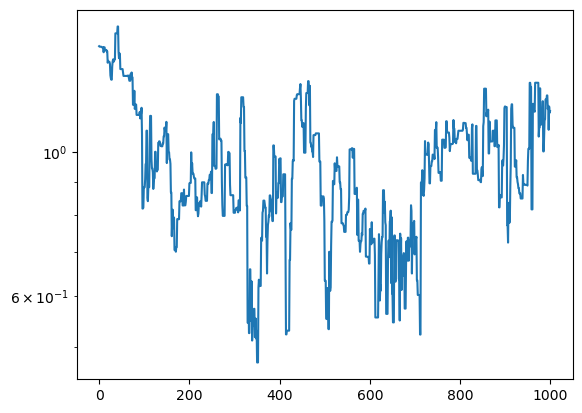

In [11]:
plt.semilogy(rc.sampler.get_chain()[:,9,2])

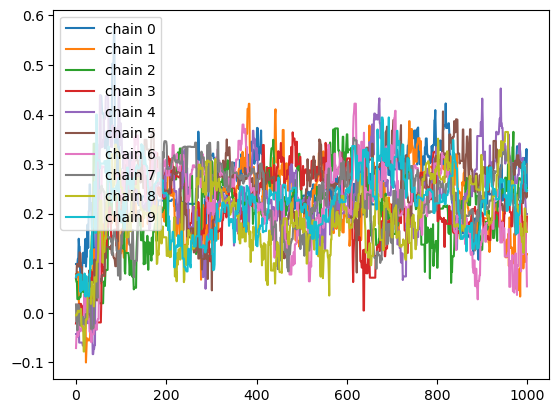

In [13]:
for i in range(10):
    plt.plot(rc.sampler.get_chain()[:,i,4], label='chain %d' % i)

plt.legend()

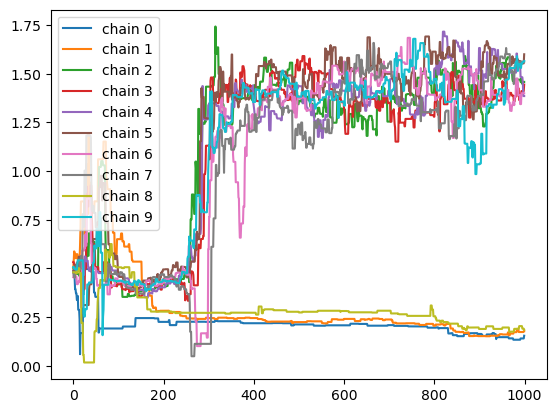

In [32]:
for i in range(10):
    plt.plot(rc.sampler.get_chain()[:,i,3], label='chain %d' % i)

plt.legend()

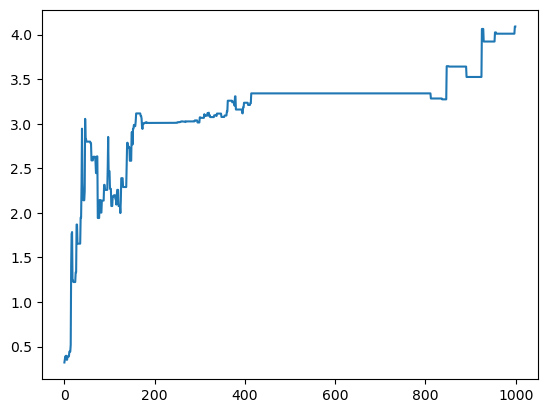

In [13]:
plt.plot(rc.sampler.get_chain()[:,6,2], label='chain %d' % i)


In [26]:
rc.sampler.get_chain()[1000,6,3]

4.12678368465147e-05

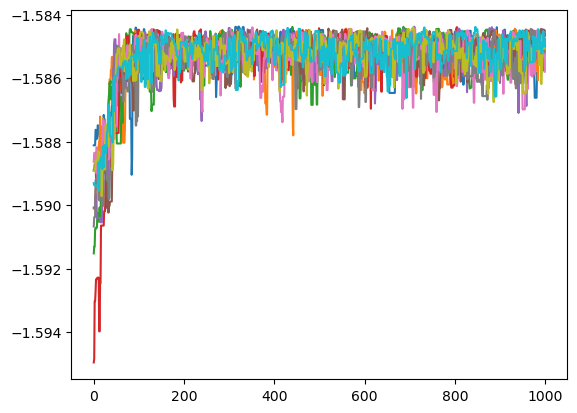

In [16]:
for i in range(10):
    plt.plot(rc.sampler.get_log_prob()[:,i]/13**2/38 * 2)

In [144]:
cleaned_chain = []

for i in range(10):
    chain = rc.sampler.get_chain()[:,i].copy()

    for j in range(len(chain)):
        if chain[j,2] < chain[j,3]:
            chain[j,2], chain[j,3] = chain[j,3], chain[j,2]
            chain[j,4] += np.pi/2

    cleaned_chain.append(chain)

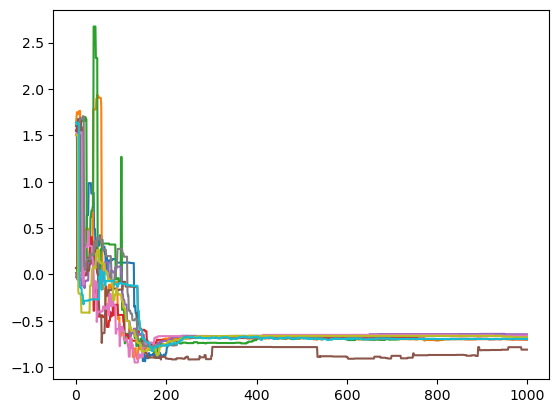

In [145]:
for i in range(10):
    plt.plot(np.array(cleaned_chain)[i,:,4])

In [146]:
np.shape(cleaned_chain)

(10, 1000, 5)

In [147]:
flat_chain = np.transpose(cleaned_chain, axes=(1,0,2)).reshape(-1, 5)

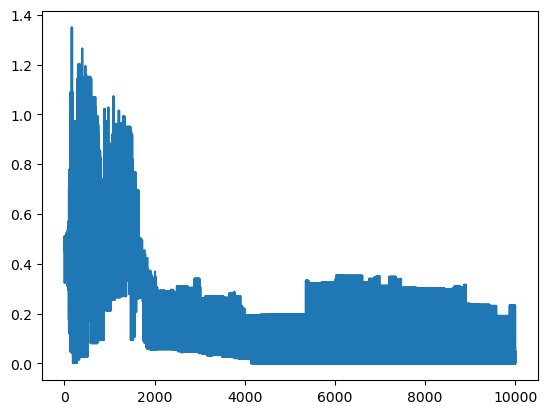

In [148]:
plt.plot(flat_chain[:,3])

In [149]:
np.pi/2

1.5707963267948966

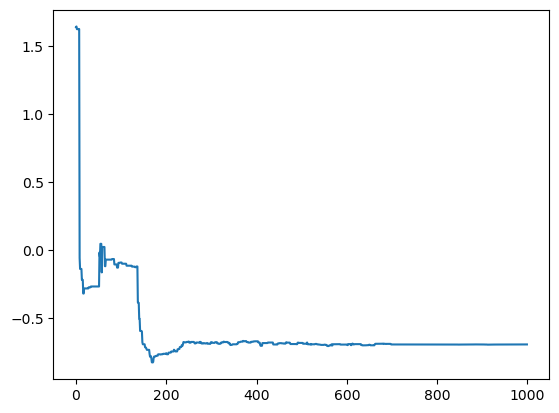

In [150]:
plt.plot(chain[:1000,4])

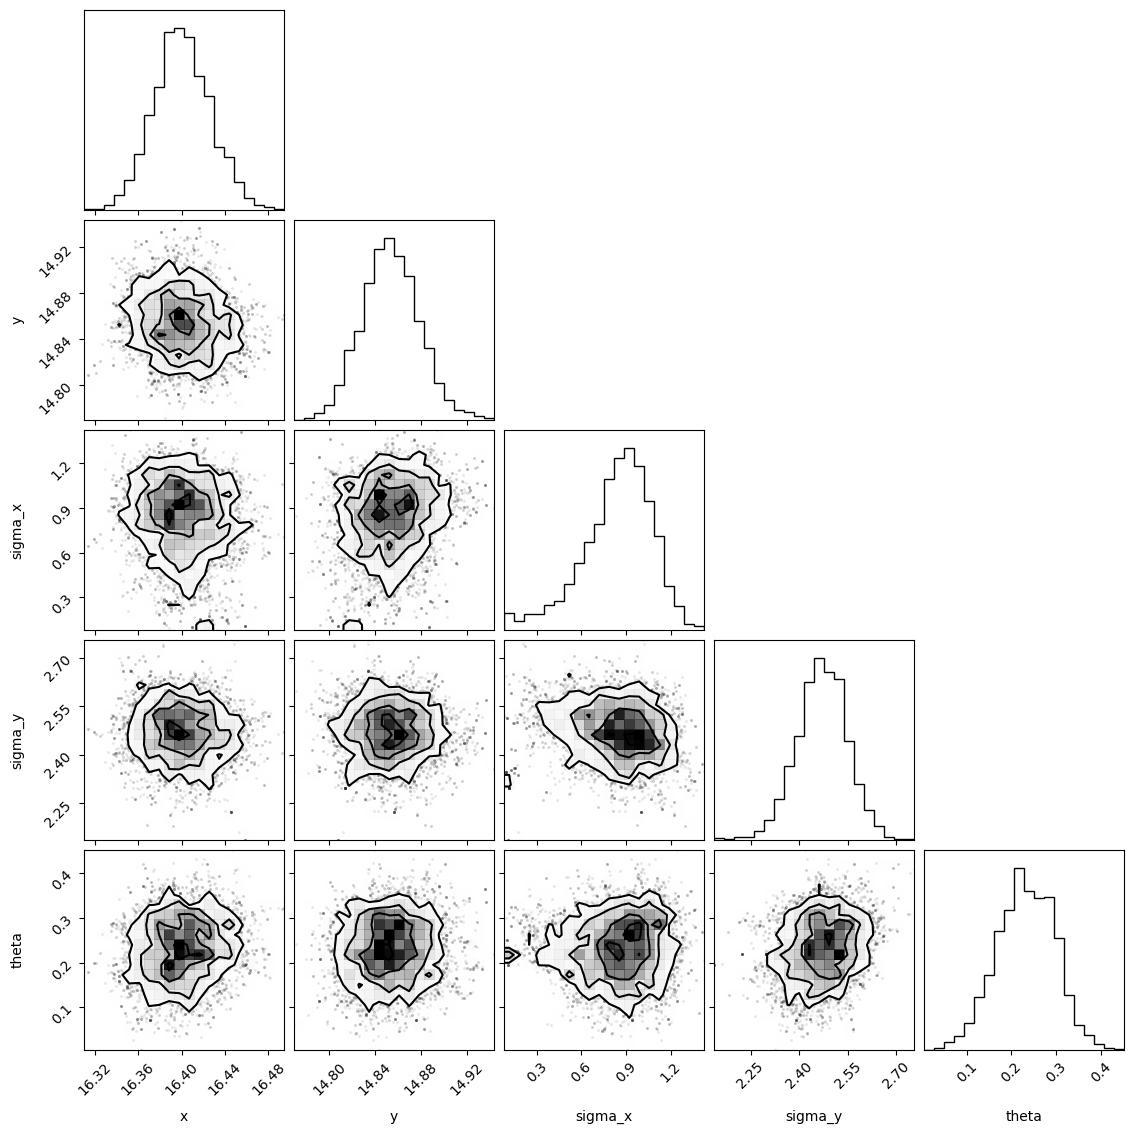

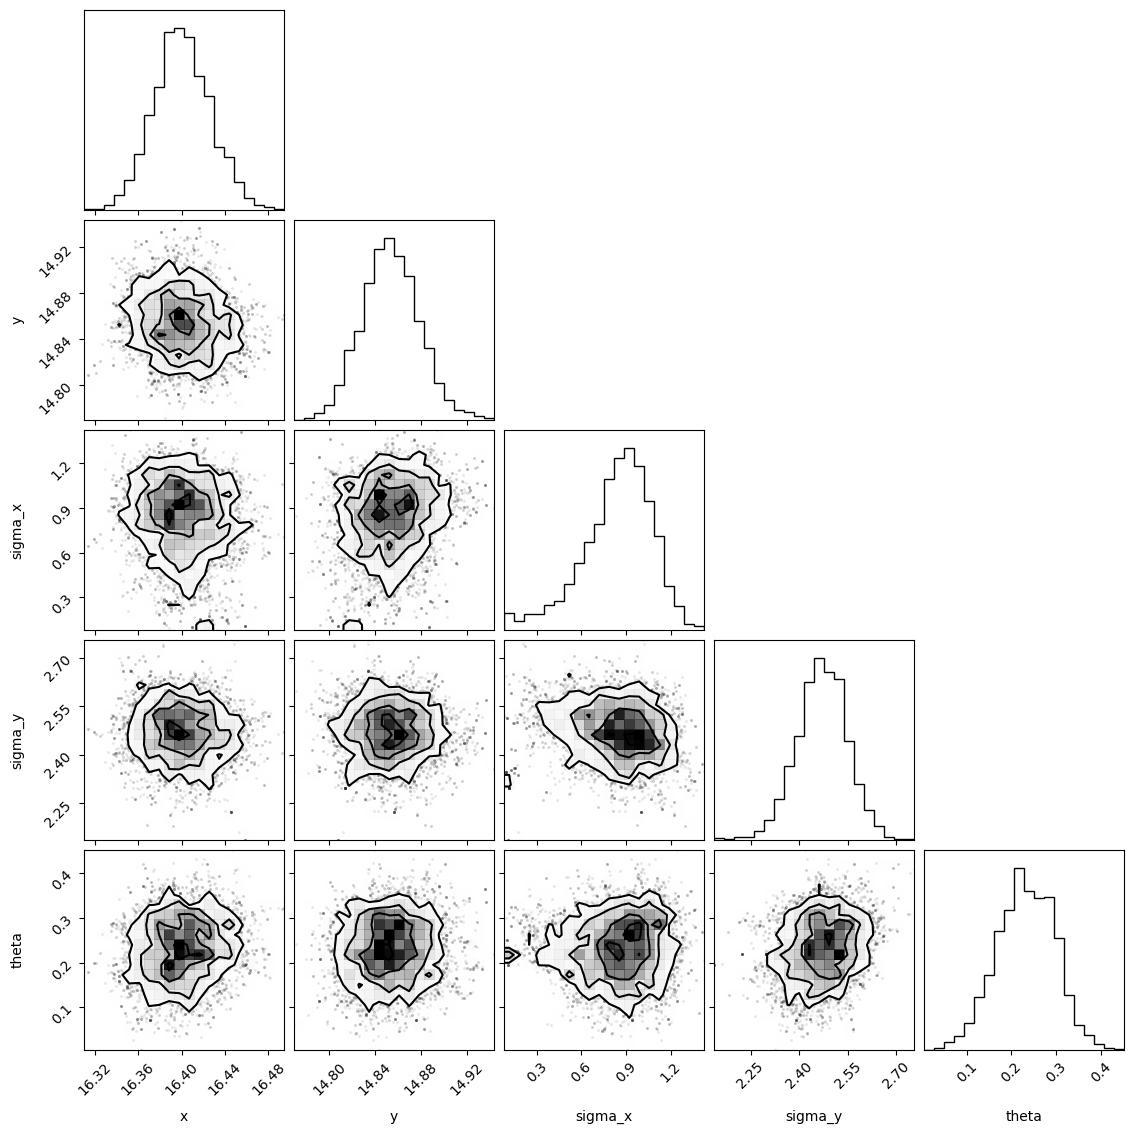

In [15]:
import corner
flat_chain = rc.sampler.get_chain(discard=100, flat=True)
corner.corner(flat_chain, labels=['x', 'y', 'sigma_x', 'sigma_y', 'theta'])

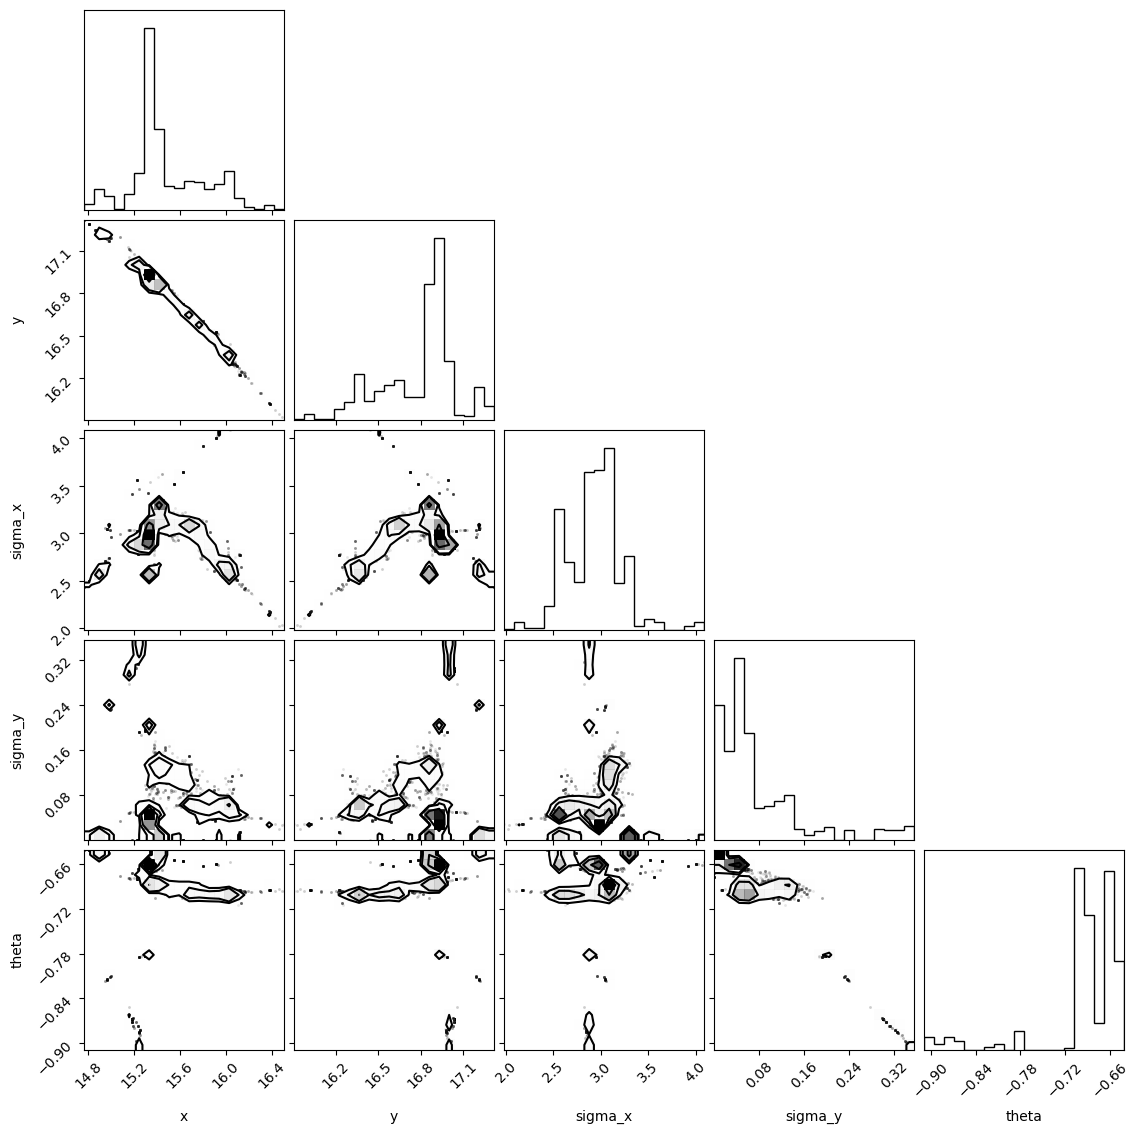

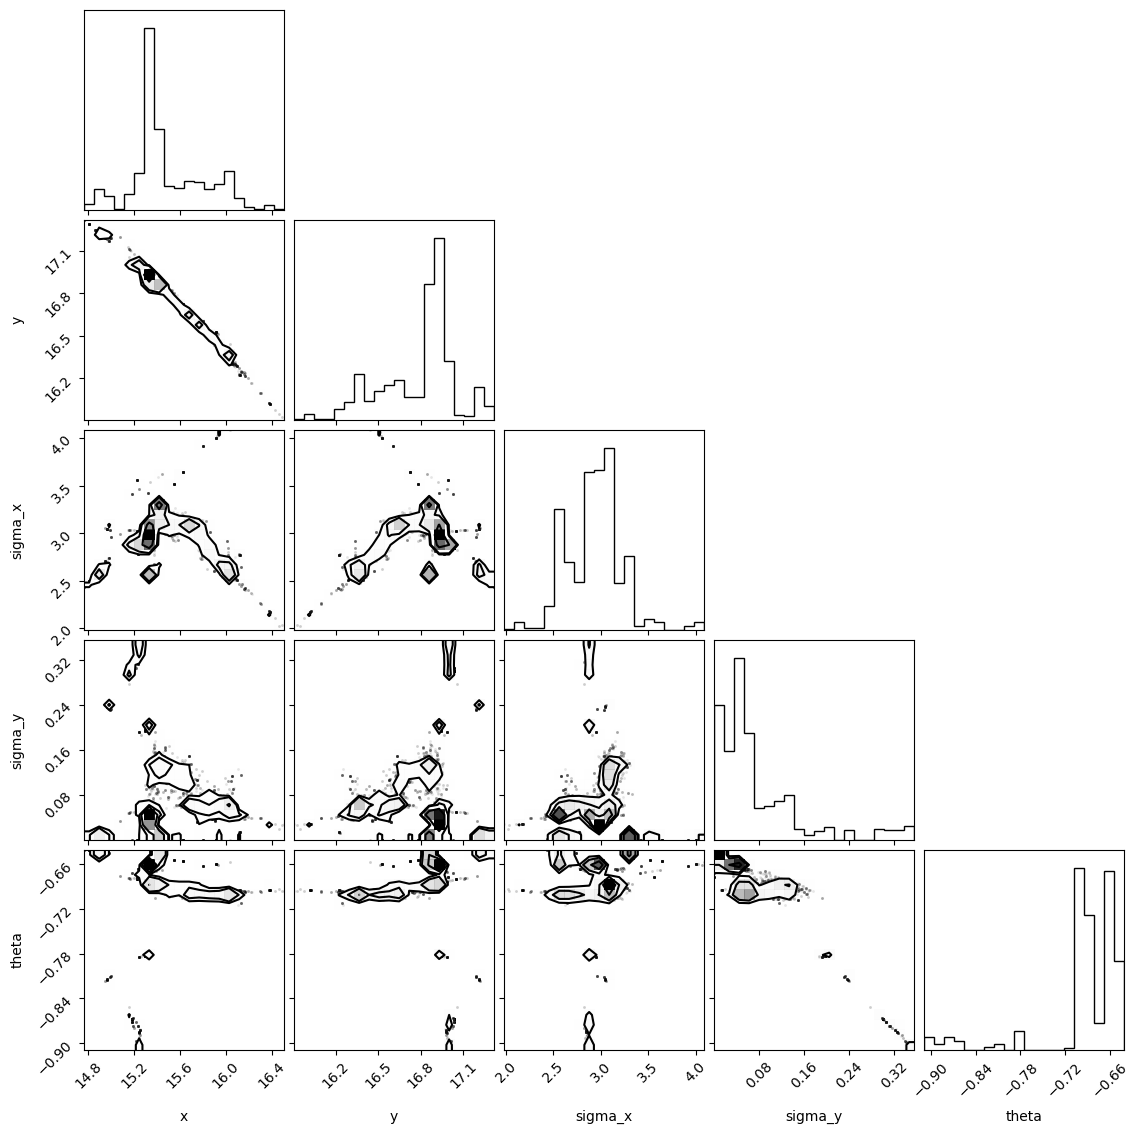

In [151]:
import corner
corner.corner(flat_chain[4000:,:], labels=['x', 'y', 'sigma_x', 'sigma_y', 'theta'])

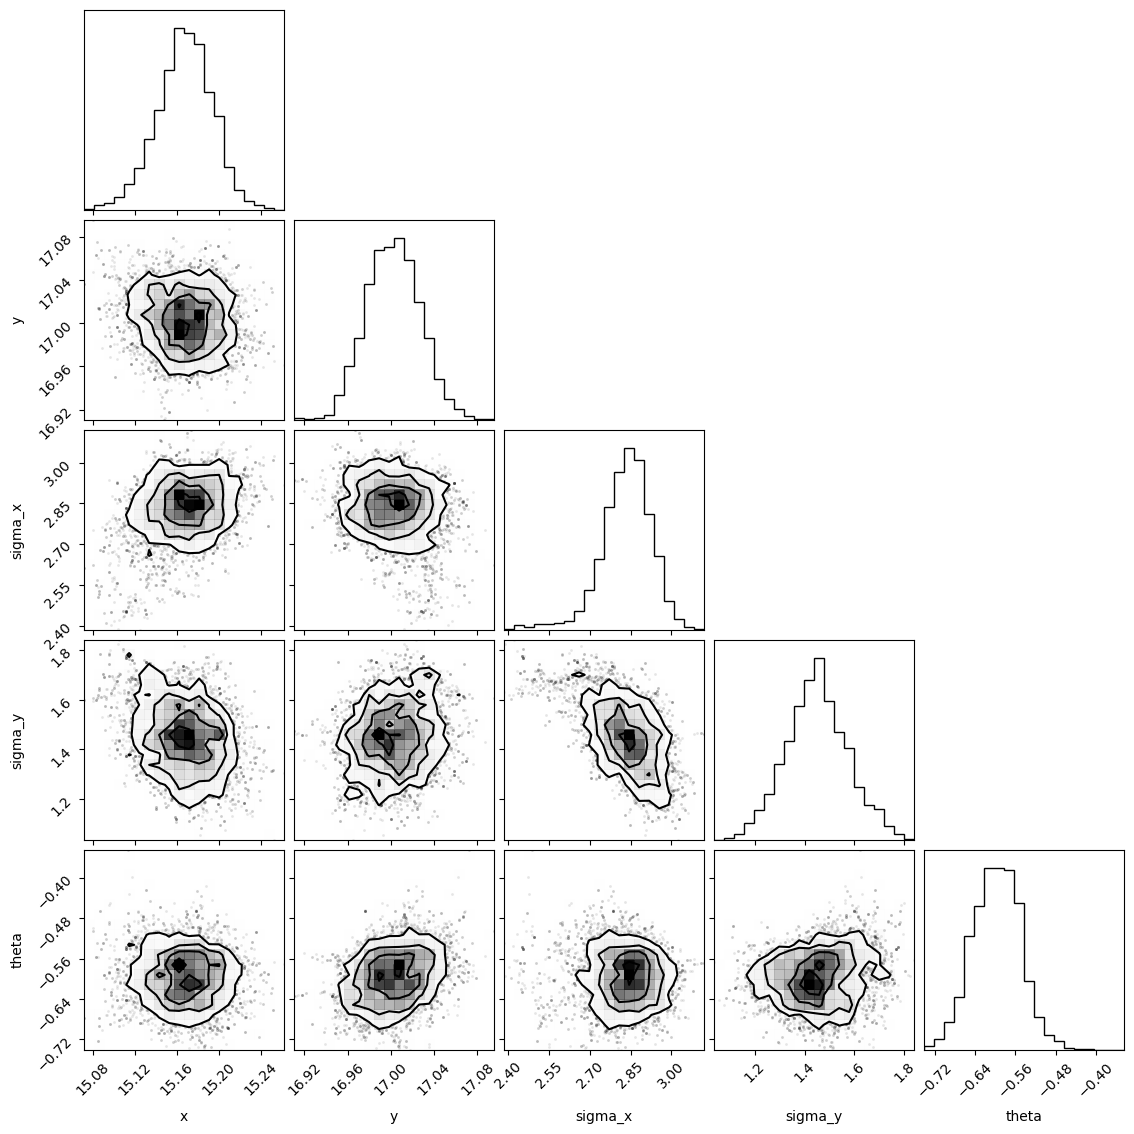

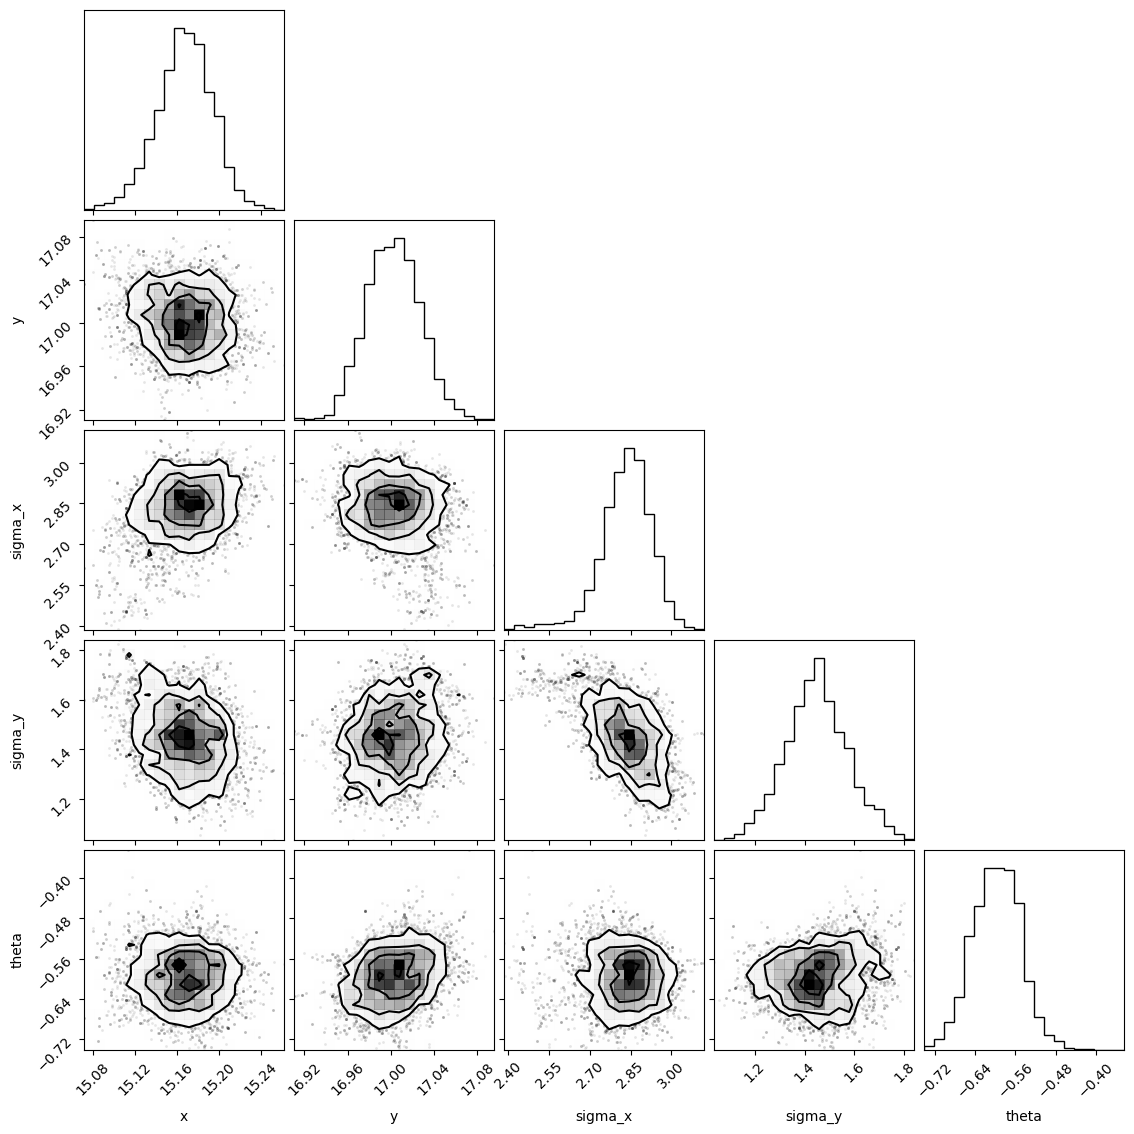

In [69]:
import corner
corner.corner(chain[1000:,:], labels=['x', 'y', 'sigma_x', 'sigma_y', 'theta'])

In [113]:
np.shape(rc.sampler.get_chain())

(500, 10, 5)

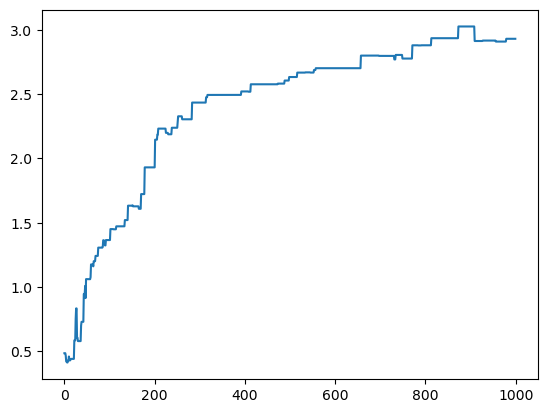

In [57]:
plt.plot(rc.sampler.get_chain()[:,0,3])

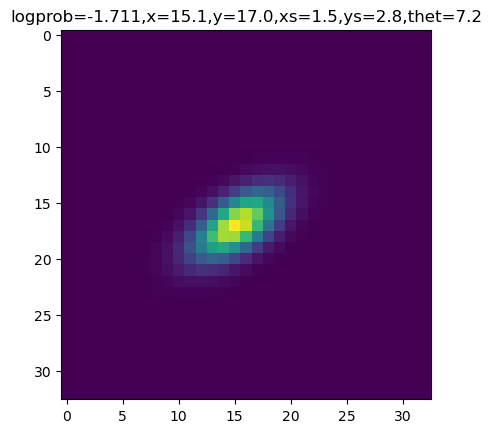

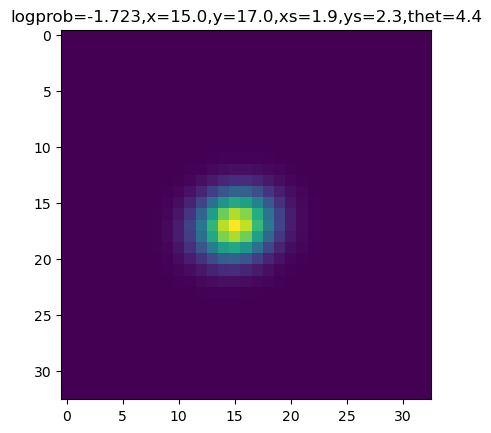

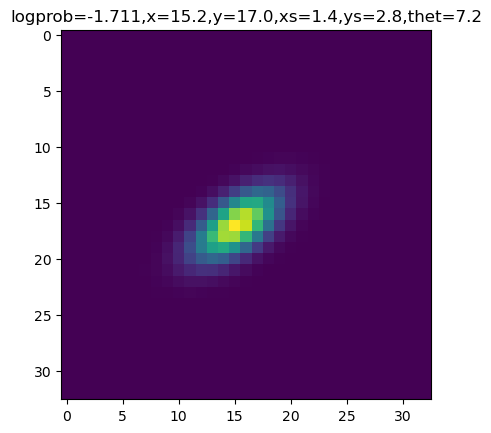

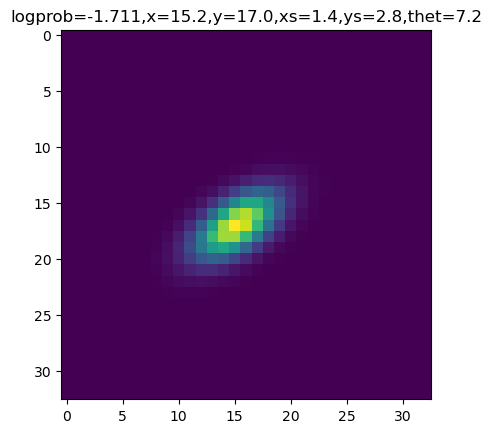

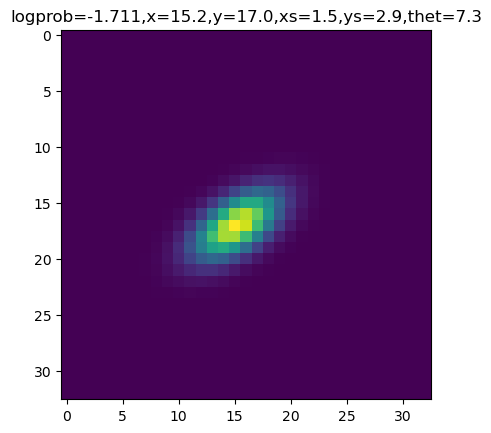

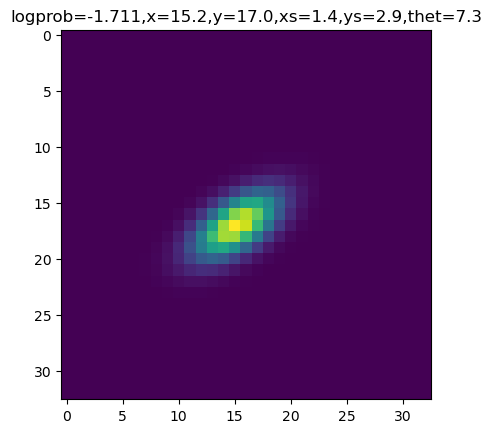

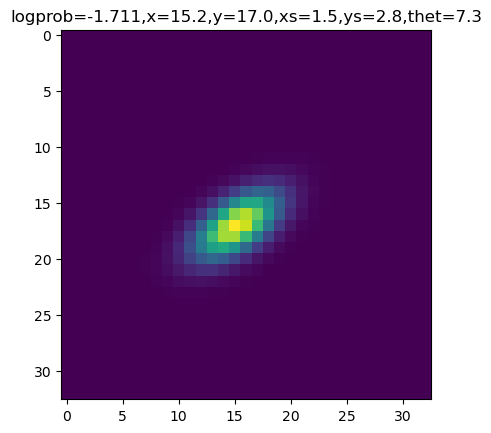

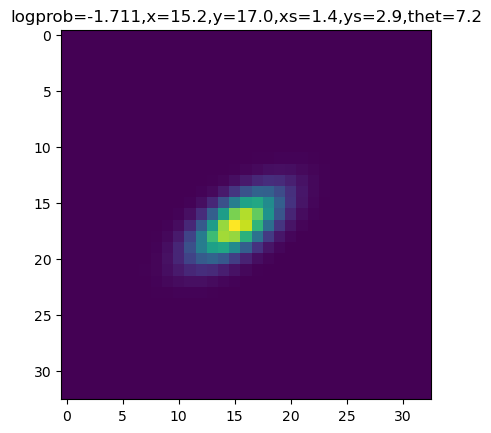

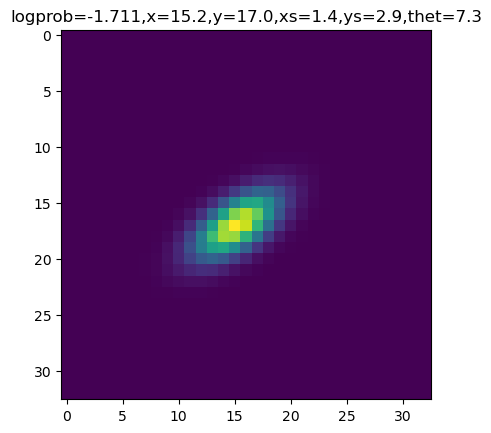

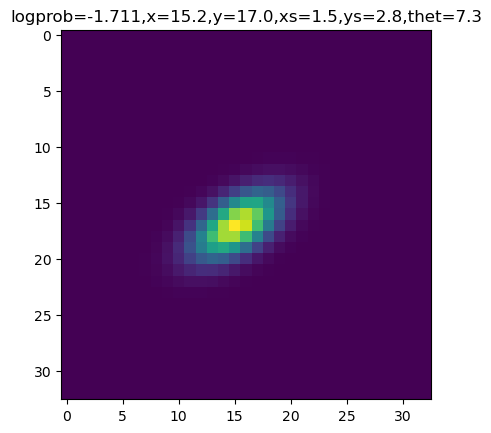

In [110]:
# final_values = np.mean(chain[2000:], axis=0)

for i in range(10):
    final_values = np.mean(rc.sampler.get_chain()[400:,i,:], axis=0)
    logprobs = np.mean(rc.sampler.get_log_prob()[400:,i])

    from astropy.modeling.functional_models import Gaussian2D

    gauss = Gaussian2D(amplitude=1, x_mean=final_values[0], y_mean=final_values[1], 
                    x_stddev=final_values[2], y_stddev=final_values[3],
                    theta=final_values[4])

    xg, yg = np.meshgrid(np.arange(33), np.arange(33))
    plt.imshow(gauss(xg,yg))
    plt.title('logprob=%.3f,x=%.1f,y=%.1f,xs=%.1f,ys=%.1f,thet=%.1f' % (logprobs/38/13**2 * 2, final_values[0], final_values[1], final_values[2], final_values[3], final_values[4]))
    plt.show()

Text(0.5, 1.0, 'x=15.2,y=17.0,xs=1.4,ys=2.8,thet=7.2')

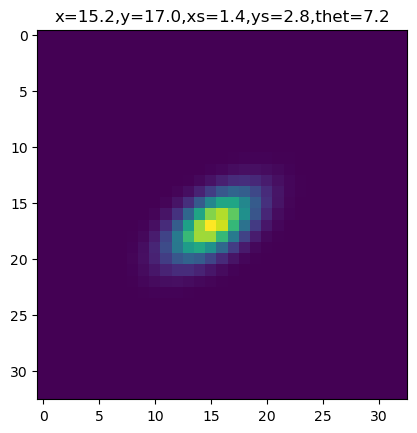

In [179]:
fitter2.rc.compute_ll(final_values) / 13**2/38 * 2

-1.7313765074819865

In [87]:
chains = []
for specind in np.arange(105,110):
    timeind = 3

    fitter2 = fit.PLMapFit(matrix_file = '/Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind%d_ngrid33_t%d.fits' % (specind, timeind))
    fitter2.prepare_data(fiber_inds)
    rc = fitter2.run_mcmc_gaussian(np.array([16,16,0.5,0.5,0]), niter = 500, ini_ball_size=0.05)

    cleaned_chain = []

    for i in range(10):
        chain = rc.sampler.get_chain()[:,i].copy()

        for j in range(len(chain)):
            if chain[j,2] < chain[j,3]:
                chain[j,2], chain[j,3] = chain[j,3], chain[j,2]
                chain[j,4] += np.pi/2

        cleaned_chain.append(chain)
    
    # chain = rc.sampler.get_chain(flat=True)

    chains.append(cleaned_chain)

loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind105_ngrid33_t3.fits specind 105
preparing data for specind 105


 72%|███████▏  | 362/500 [00:28<00:10, 13.40it/s]/Users/yjkim/Documents/PLred/PLred/imgrecon.py:745: RuntimeWarning: invalid value encountered in divide
  _im = _im / np.nansum(_im) # normalize the fluxes
100%|██████████| 500/500 [00:38<00:00, 12.83it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind106_ngrid33_t3.fits specind 106
preparing data for specind 106


100%|██████████| 500/500 [00:41<00:00, 12.15it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind107_ngrid33_t3.fits specind 107
preparing data for specind 107


100%|██████████| 500/500 [00:39<00:00, 12.68it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind108_ngrid33_t3.fits specind 108
preparing data for specind 108


100%|██████████| 500/500 [00:45<00:00, 11.04it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind109_ngrid33_t3.fits specind 109
preparing data for specind 109


100%|██████████| 500/500 [00:41<00:00, 12.12it/s]


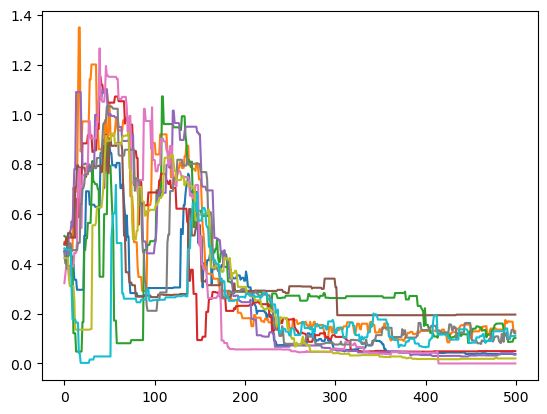

In [100]:
for i in range(10):
    plt.plot(np.array(chains)[4][i,:,3])


In [65]:
np.shape(chains[0])

(10, 500, 5)

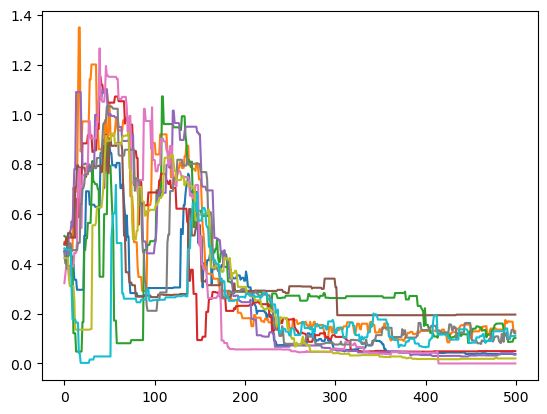

In [83]:
for i in range(10):
    plt.plot(np.array(chains)[4][i,:,3])


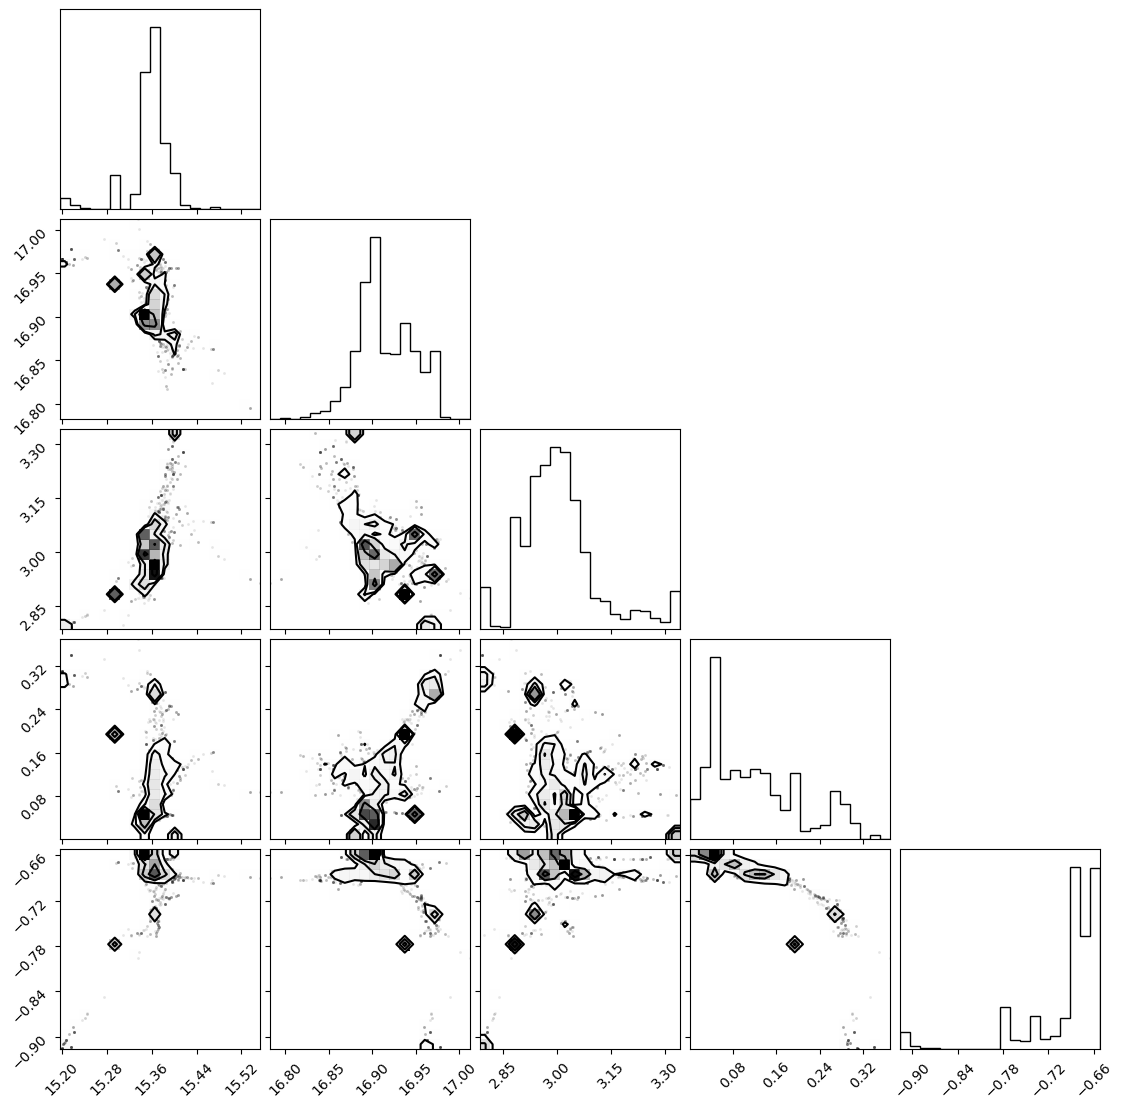

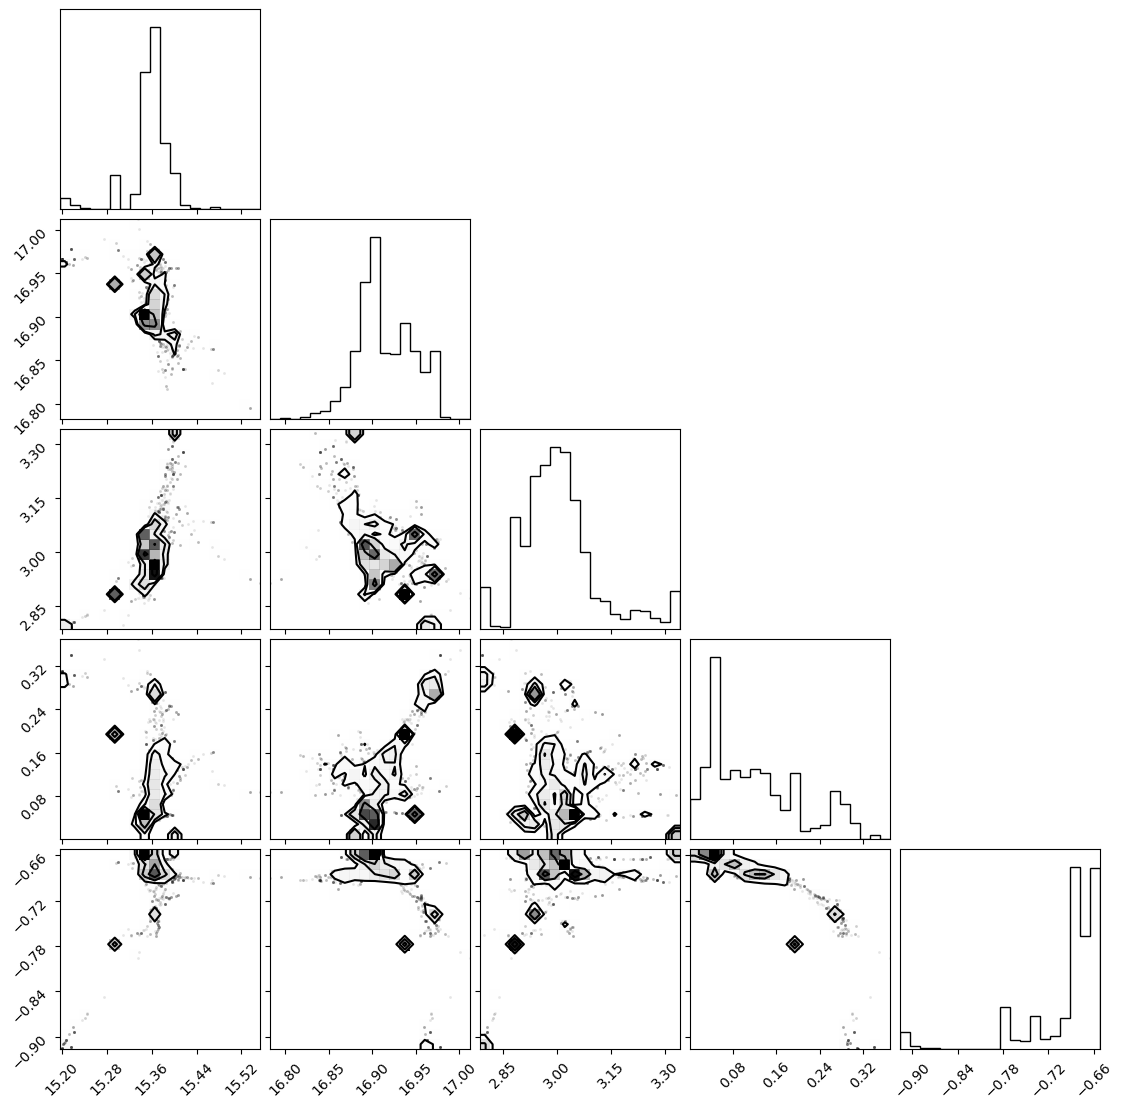

In [85]:
flat_chain = np.transpose(chains[4], axes=(1,0,2)).reshape(-1, 5)
corner.corner(flat_chain[2000:])

In [62]:
chains = []
for specind in np.arange(100,116):
    timeind = 3

    fitter2 = fit.PLMapFit(matrix_file = '/Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind%d_ngrid33_t%d.fits' % (specind, timeind))
    fitter2.prepare_data(fiber_inds)
    rc = fitter2.run_mcmc_pointsource(1, np.array([16,16]))
    chain = rc.sampler.get_chain(flat=True)

    chains.append(chain)

loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind100_ngrid33_t3.fits specind 100
preparing data for specind 100


100%|██████████| 1000/1000 [00:01<00:00, 865.39it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind101_ngrid33_t3.fits specind 101
preparing data for specind 101


100%|██████████| 1000/1000 [00:00<00:00, 1041.89it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind102_ngrid33_t3.fits specind 102
preparing data for specind 102


100%|██████████| 1000/1000 [00:00<00:00, 1037.80it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind103_ngrid33_t3.fits specind 103
preparing data for specind 103


100%|██████████| 1000/1000 [00:00<00:00, 1047.50it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind104_ngrid33_t3.fits specind 104
preparing data for specind 104


100%|██████████| 1000/1000 [00:00<00:00, 1048.81it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind105_ngrid33_t3.fits specind 105
preparing data for specind 105


100%|██████████| 1000/1000 [00:01<00:00, 905.34it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind106_ngrid33_t3.fits specind 106
preparing data for specind 106


100%|██████████| 1000/1000 [00:00<00:00, 1049.97it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind107_ngrid33_t3.fits specind 107
preparing data for specind 107


100%|██████████| 1000/1000 [00:01<00:00, 922.09it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind108_ngrid33_t3.fits specind 108
preparing data for specind 108


100%|██████████| 1000/1000 [00:00<00:00, 1004.63it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind109_ngrid33_t3.fits specind 109
preparing data for specind 109


100%|██████████| 1000/1000 [00:00<00:00, 1040.60it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind110_ngrid33_t3.fits specind 110
preparing data for specind 110


100%|██████████| 1000/1000 [00:01<00:00, 886.03it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind111_ngrid33_t3.fits specind 111
preparing data for specind 111


100%|██████████| 1000/1000 [00:00<00:00, 1047.78it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind112_ngrid33_t3.fits specind 112
preparing data for specind 112


100%|██████████| 1000/1000 [00:00<00:00, 1069.82it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind113_ngrid33_t3.fits specind 113
preparing data for specind 113


100%|██████████| 1000/1000 [00:00<00:00, 1042.63it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind114_ngrid33_t3.fits specind 114
preparing data for specind 114


100%|██████████| 1000/1000 [00:00<00:00, 1007.62it/s]


loading model
Matrix loaded from  /Users/yjkim/Documents/OnskyDemoPaper/results/matrices/matrix_specind115_ngrid33_t3.fits specind 115
preparing data for specind 115


100%|██████████| 1000/1000 [00:01<00:00, 941.17it/s]


In [21]:
chains = np.array(chains)

In [23]:
chains

array([[[ 1.58903469e+01,  1.60198121e+01,  4.05733034e-01,
          4.27250103e-01,  6.11181186e-02],
        [ 1.60316359e+01,  1.60138419e+01,  4.75211283e-01,
          5.12168719e-01,  9.71649453e-02],
        [ 1.60976936e+01,  1.58527057e+01,  5.11294607e-01,
          5.58969134e-01,  9.04111766e-02],
        ...,
        [ 1.66804338e+01,  1.54287817e+01,  2.71872000e-03,
         -3.06950861e-02,  1.92056027e+00],
        [ 1.28373737e+01,  1.73391623e+01,  3.06460385e+00,
         -2.78679617e-04, -1.20343798e+01],
        [ 1.54708007e+01,  1.56158593e+01,  3.20430459e-01,
          6.23451454e-03, -6.26818994e+00]],

       [[ 1.58903469e+01,  1.60198121e+01,  4.05733034e-01,
          4.27250103e-01,  6.11181186e-02],
        [ 1.60316359e+01,  1.60138419e+01,  4.75211283e-01,
          5.12168719e-01,  9.71649453e-02],
        [ 1.61007189e+01,  1.58703779e+01,  5.27499163e-01,
          5.22891288e-01,  1.35291684e-01],
        ...,
        [ 2.31336780e+09, -1.6734135

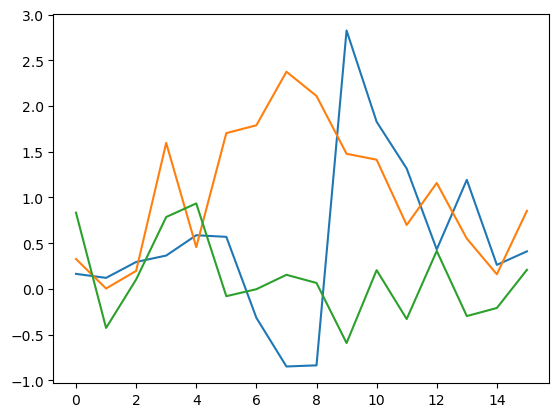

In [35]:
# plt.plot(np.median(chains[:,1000:,:],axis=1)[:,0])
# plt.plot(np.median(chains[:,1000:,:],axis=1)[:,1])
plt.plot(np.median(chains[:,1000:,:],axis=1)[:,2])
plt.plot(np.median(chains[:,1000:,:],axis=1)[:,3])
plt.plot(np.median(chains[:,1000:,:],axis=1)[:,4])
# plt.plot(np.average(chains[:,1000:,:],axis=1)[2:,0])

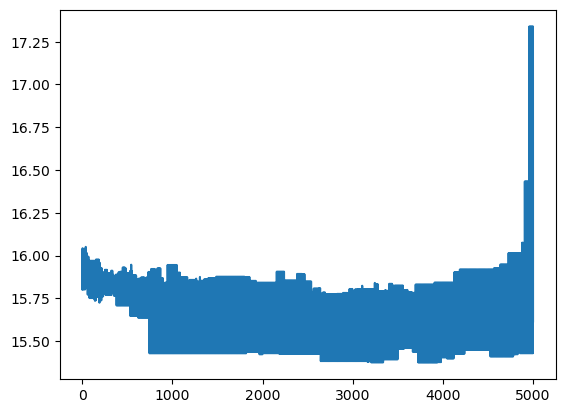

In [48]:
plt.plot(chains[0,:,1])

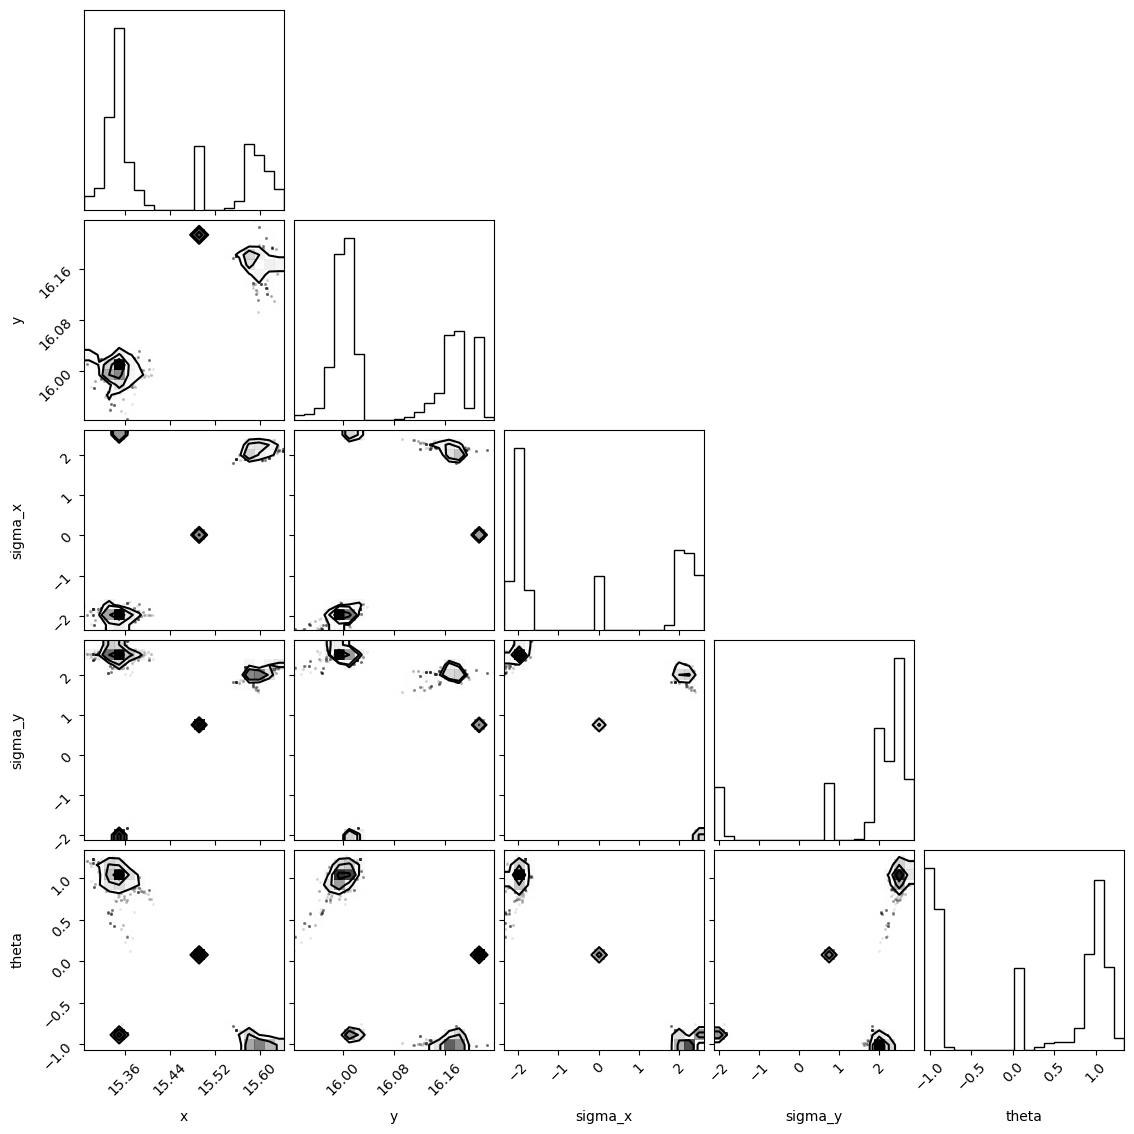

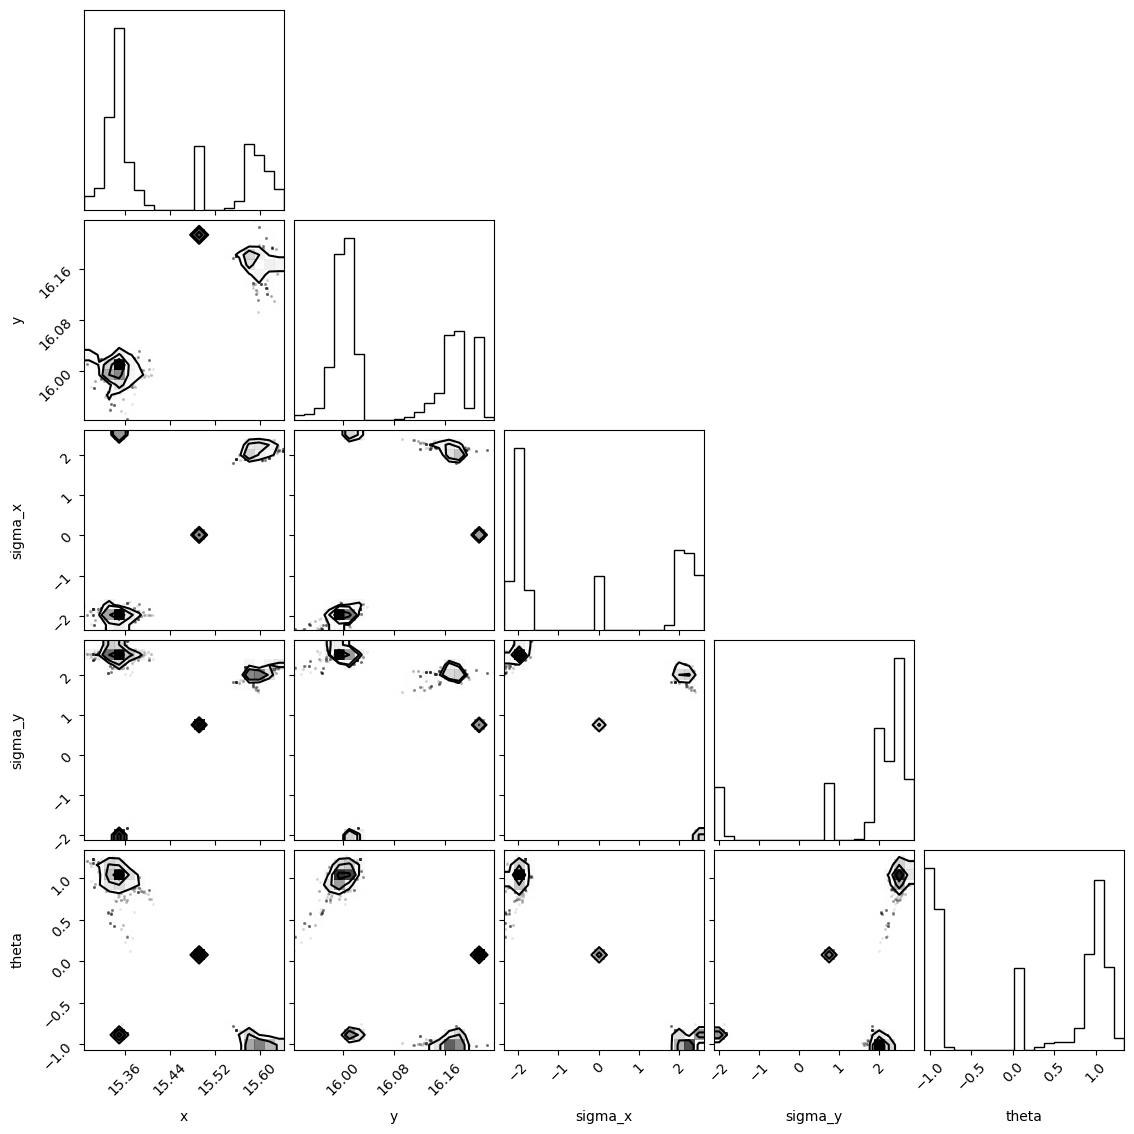

In [41]:
corner.corner(chains[8,2000:,:], labels=['x', 'y', 'sigma_x', 'sigma_y', 'theta'])

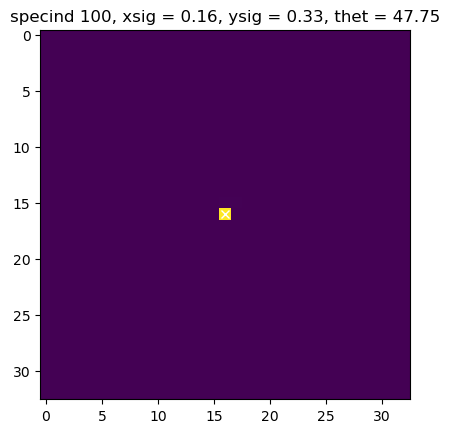

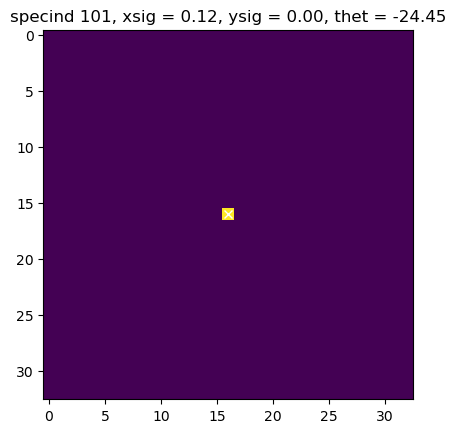

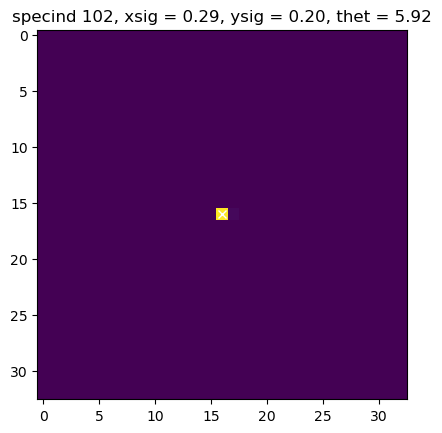

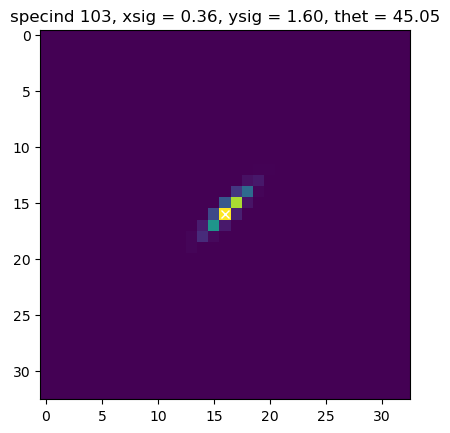

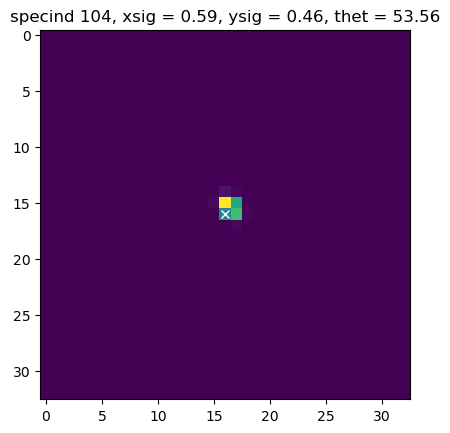

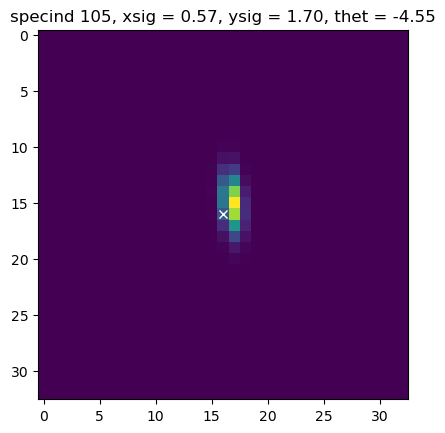

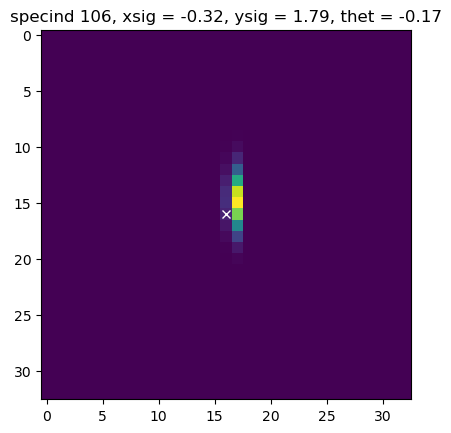

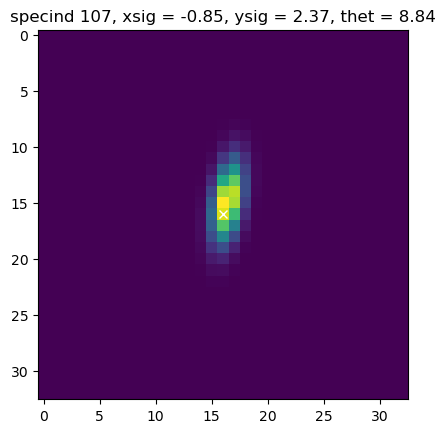

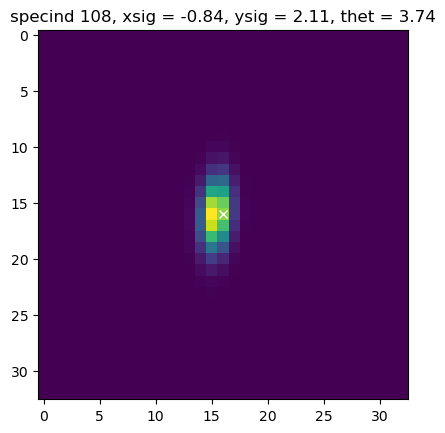

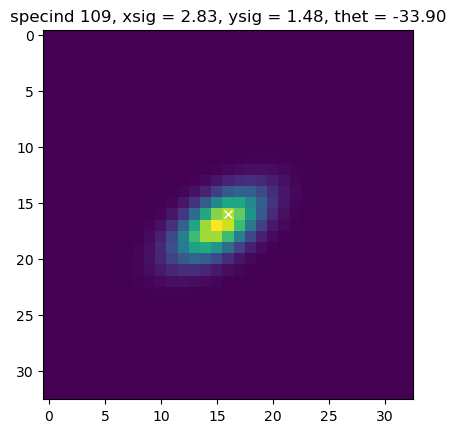

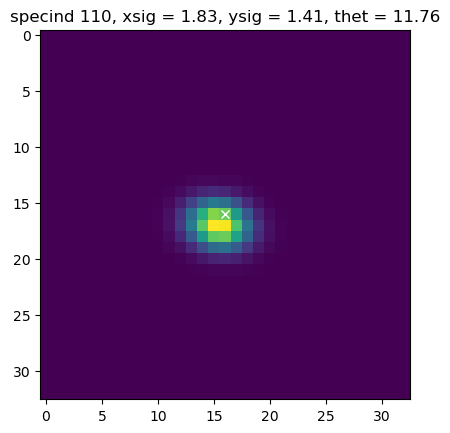

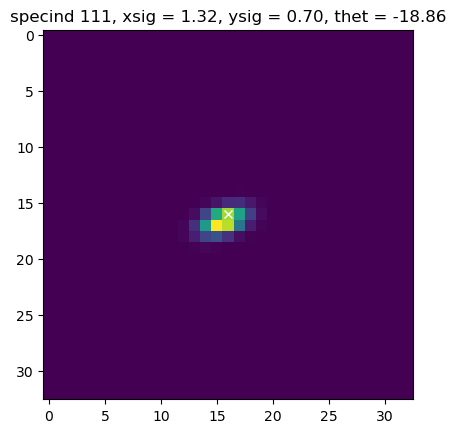

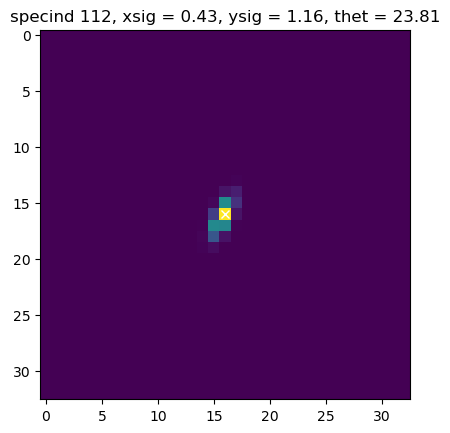

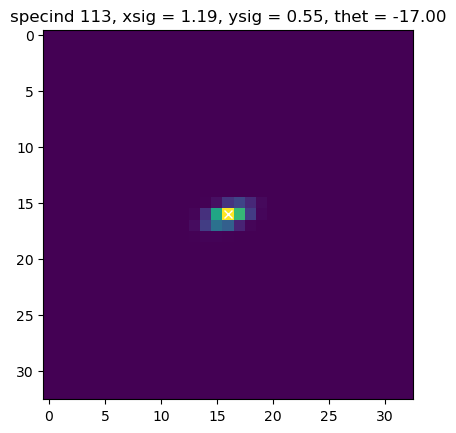

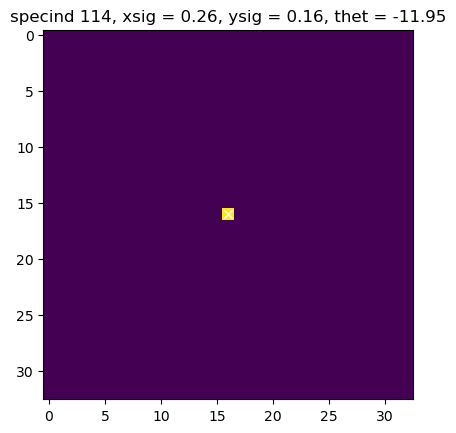

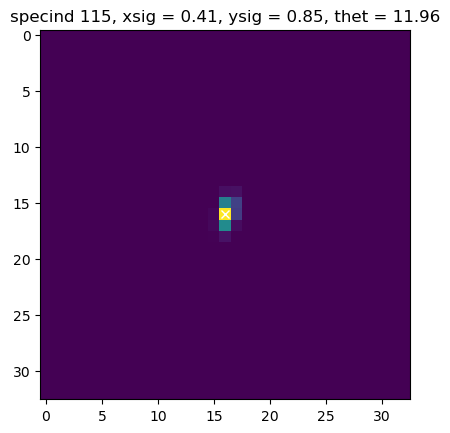

In [39]:
xg, yg = np.meshgrid(np.arange(33), np.arange(33))

for i in range(len(chains)):

    final_values = np.median(chains[i,1000:,:],axis=0)
    gauss = Gaussian2D(amplitude=1, x_mean=final_values[0], y_mean=final_values[1], 
                    x_stddev=final_values[2], y_stddev=final_values[3],
                    theta=final_values[4])

    plt.title('specind %d, xsig = %.2f, ysig = %.2f, thet = %.2f' % (np.arange(100, 116)[i], final_values[2], final_values[3], np.rad2deg(final_values[4])))
    
    plt.imshow(gauss(xg,yg))
    plt.plot(16,16,'x',color='white')
    plt.show()

In [64]:
np.shape(chains)

(16, 10000, 2)

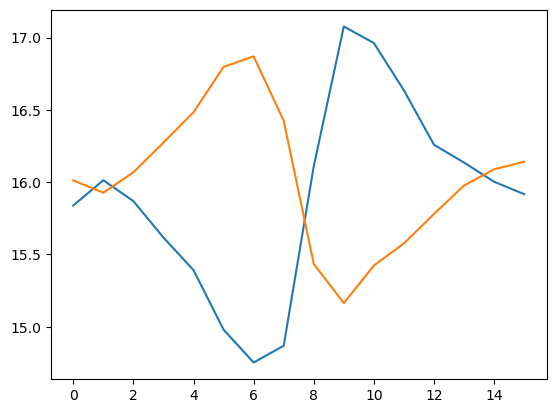

In [66]:
plt.plot(np.average(chains[:,1000:,:],axis=1)[:,0])
plt.plot(np.average(chains[:,1000:,:],axis=1)[:,1])

In [58]:
chain = rc.sampler.get_chain(flat=True)

In [59]:
np.shape(chain)

(10000, 2)

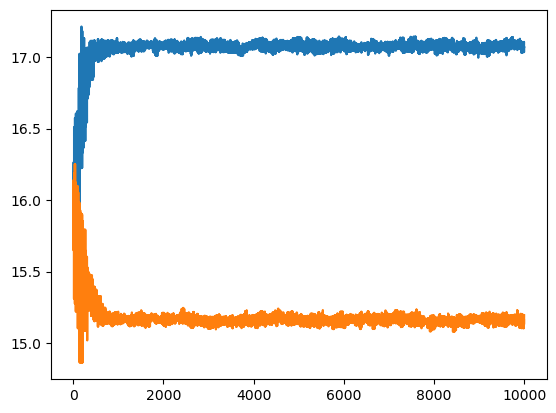

In [60]:
plt.plot(chain[:,0])
plt.plot(chain[:,1])

2025-02-25 20:49:33,250 - WARNING - Too few points to create valid contours


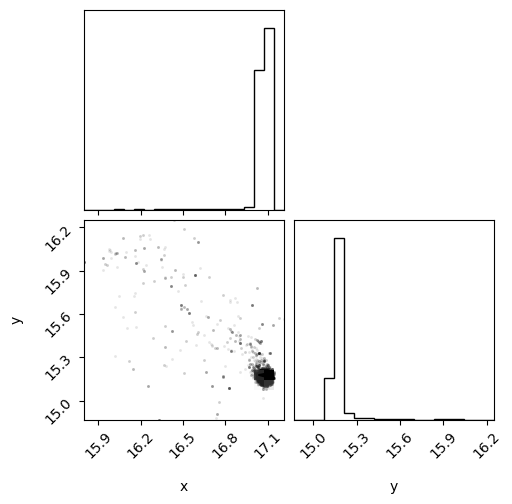

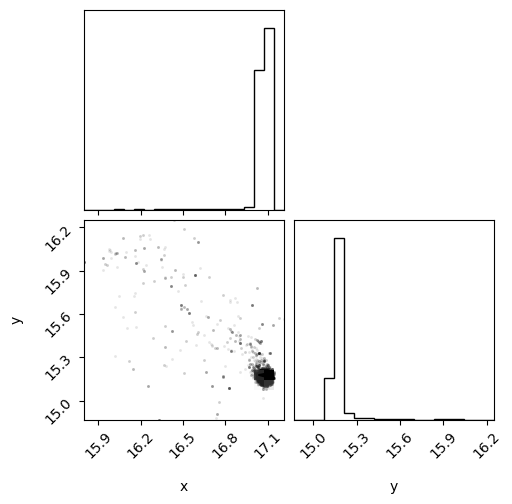

In [61]:
import corner

corner.corner(chain, labels=['x', 'y'])#, truths=[16, 16])